# Plotting the SFRD(z,Z) compared to TNG

In [6]:
import os, sys
import h5py as h5
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import astropy.units as u
from astropy import constants as const

from scipy import interpolate
from scipy.optimize import minimize
from scipy.optimize import curve_fit

# from astropy.cosmology import WMAP9, z_at_value
from astropy.cosmology import Planck18  as cosmo# Planck 2018
from astropy.cosmology import z_at_value
from astropy.table import Table

from matplotlib import rc
import matplotlib
from matplotlib import ticker, cm
import matplotlib.gridspec as gridspec
from matplotlib import cm
from matplotlib.colors import ListedColormap

############################
# Custom scripts
sys.path.append( str(os.getcwd()) + '/../')
import get_ZdepSFRD as Z_SFRD
import paths
import init_values as In
 
############################
##PLOT setttings
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
plt.rc('font', family='serif')
rc('text', usetex=False)
fsize, SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE = 30,20,20,30
for obj in ['axes','xtick','ytick']:
    plt.rc(obj, labelsize=MEDIUM_SIZE)          # controls default text sizes
for obj in ['figure','axes']:
    plt.rc(obj, titlesize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize




Using original TNG
step_obs_logZ 0.16666666666666607
np.amax(Obs_cosmic_SFR/dlogZ) 0.08268044129983945


/Users/lieke/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:201: UserWarning: Log scale: values of z <= 0 have been masked
/Users/lieke/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:222: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


!!!! Obs_redshifts [2.211e+01 1.596e+01 1.253e+01 1.142e+01 1.035e+01 9.690e+00 9.280e+00
 8.680e+00 8.220e+00 7.780e+00 7.400e+00 7.150e+00 6.620e+00 6.110e+00
 5.940e+00 5.610e+00 5.300e+00 5.060e+00 4.720e+00 4.480e+00 4.220e+00
 4.050e+00 3.740e+00 3.520e+00 3.310e+00 3.030e+00 2.910e+00 2.750e+00
 2.590e+00 2.460e+00 2.330e+00 2.220e+00 2.110e+00 2.010e+00 1.910e+00
 1.830e+00 1.750e+00 1.670e+00 1.610e+00 1.540e+00 1.500e+00 1.420e+00
 1.360e+00 1.310e+00 1.250e+00 1.210e+00 1.160e+00 1.120e+00 1.080e+00
 1.040e+00 1.000e+00 9.500e-01 9.200e-01 8.900e-01 8.500e-01 8.200e-01
 7.900e-01 7.600e-01 7.300e-01 7.000e-01 6.800e-01 6.500e-01 6.200e-01
 6.000e-01 5.800e-01 5.500e-01 5.200e-01 5.000e-01 4.800e-01 4.600e-01
 4.400e-01 4.200e-01 4.000e-01 3.800e-01 3.600e-01 3.500e-01 3.300e-01
 3.100e-01 3.000e-01 2.700e-01 2.600e-01 2.400e-01 2.300e-01 2.100e-01
 2.000e-01 1.800e-01 1.700e-01 1.500e-01 1.400e-01 1.300e-01 1.100e-01
 1.000e-01 8.000e-02 7.000e-02 6.000e-02 5.000e-02 3.000e-

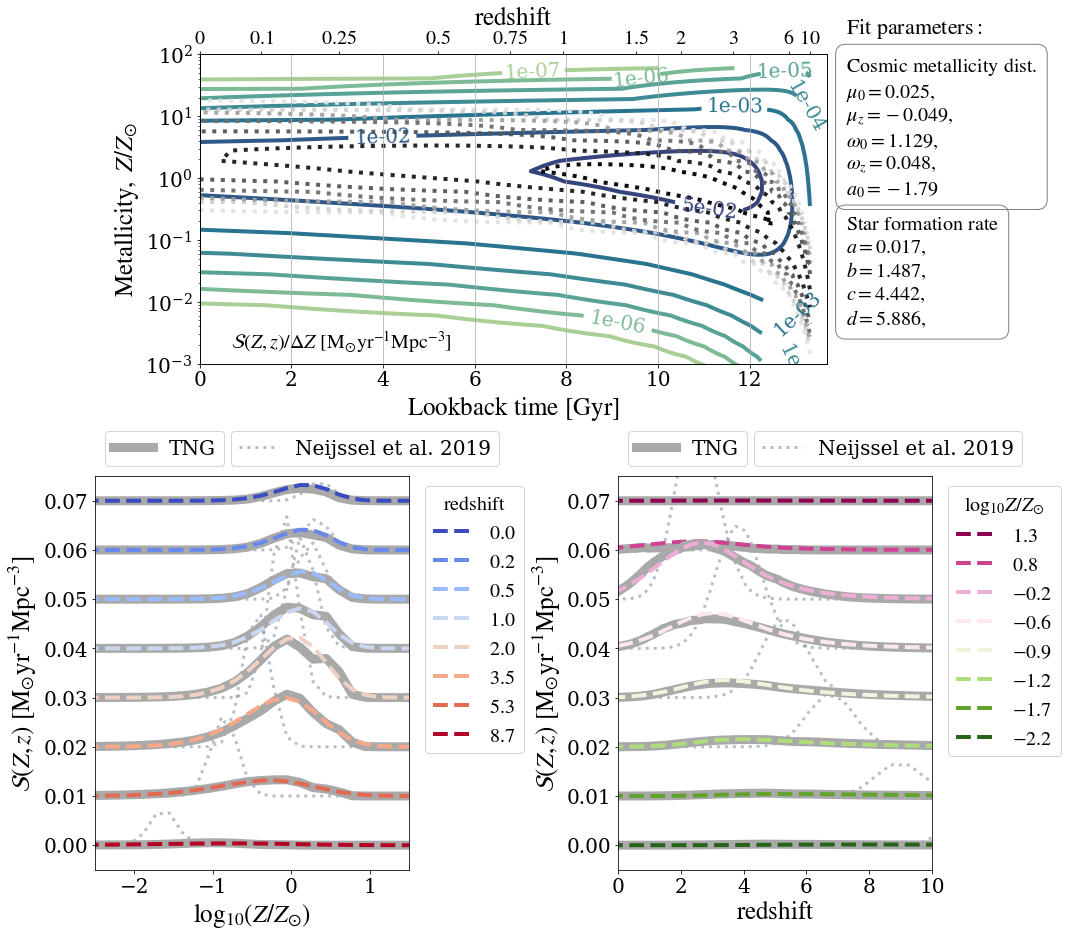

In [14]:
def Mchirp(m1, m2):
    chirp_mass = np.divide(np.power(np.multiply(m1, m2), 3./5.), np.power(np.add(m1, m2), 1./5.))
    return chirp_mass   

if __name__ == "__main__": 

    # Initialize values
    In.init()

    Zsun = 0.014 # Solar metallicity

    mu0_best, muz_best, omega0_best, omegaz_best, alpha0_best,sf_a_best, sf_b_best, sf_c_best, sf_d_best = np.loadtxt(str(paths.data)+'/'+In.fit_param_filename,unpack=True, delimiter=',')
    # mu0_best, muz_best, sigma0_best, sigmaz_best, alpha0_best,sf_a_best, sf_b_best, sf_c_best, sf_d_best = np.loadtxt(data_dir+ '/best_fit_parameters.txt',unpack=True)
    # #####################################
    # #####################################
    # mu0_best      =0.025
    # muz_best      =-0.049
    # omega0_best   =1.129
    # omegaz_best   =0.048
    # alpha0_best   =-1.778

    # #####################################
    # #####################################
    # sf_a_best     =0.017
    # sf_b_best     =1.481
    # sf_c_best     =4.452
    # sf_d_best     =5.913

    TNGlocation = str(paths.data) +'/'

    ######################################
    # SFRD comparison plot
    ######################################
    def three_panel_SFRD_plot(obs_SFRD = [], mu_0=0.025, mu_z=-0.49,alpha = -1.77, omega_0=1.129, omega_z =0.048,
                        a=0.017, b=1.481, c=4.452,  d=5.913,
                        min_logZ  = -12.0, max_logZ  =0.0, step_logZ = 0.01,
                        tmin = 0.0, tmax = 13.7, add_TNG = True, 
                       plot_dPdZcontours = True, neijssel_fit = True,
                       FITkleur="crest", dPdZ_text = '', SFR_text = ''):
        '''
        x, y, z             ---------------> redshift/lookback time, metallicities, dP/dZ
        tmin,tmax           ---------------> min and max time in Gyr to show as xlim 
        DCO, DCO_mask       ---------------> table of double compact objects, + mask of which to include in plot 
        kleur, kleurlabel   ---------------> colour/colour label of contour
        savestr             ---------------> string added to save name of plot
        min_logZ_COMPAS     ---------------> min ln(metal) that ocurs in COMPAS
        max_logZ_COMPAS     ---------------> max ln(metal) that ocurs in COMPAS
        '''
        ######################################
        # Create the Figure
        #     fig, ax = plt.subplots(figsize = (15,10))
        fig = plt.figure(figsize = (15,15))
        gs = gridspec.GridSpec(10, 8)
        gs.update(wspace=0.0, hspace=0.5)
        ax        = plt.subplot(gs[0:4, 1:7])
        ax_metals = plt.subplot(gs[5:, :3])
        ax_redsh  = plt.subplot(gs[5:, 5:8])

        ######################################
        
        fit_values_string = r'$\mathrm{Cosmic \ metallicity \ dist.}$'+'\n'+\
                        r'$\mu_0=%s,$'%(np.round(mu_0,3)) +'\n'+\
                        r'$\mu_z=%s,$'%(np.round(mu_z,3)) +'\n'+\
                        r'$\omega_0=%s,$'%(np.round(omega_0,3)) +'\n'\
                        r'$\omega_z=%s,$'%(np.round(omega_z,3)) +'\n'\
                        r'$a_0=%s$'%(np.round(alpha,3))

        SFR_fit_string = r'$\mathrm{Star \ formation \ rate}$'+'\n'+\
                         '$a=%s,$'%(np.round(a,3)) +'\n'+\
                         '$b=%s,$'%(np.round(b,3)) +'\n'+\
                         '$c=%s,$'%(np.round(c,3)) +'\n'\
                         '$d=%s,$'%(np.round(d,3))



        ##############################################################################
        # Load TNG data (either original or interpolated)
        if len(obs_SFRD) == 0:
            print('Using original TNG')
            with h5.File(TNGlocation+"SFRMetallicityFromGasTNG100.hdf5", "r") as f:
                MetalBins         = f["MetalBins"][:]
                Obs_Lookbacktimes = f["Lookbacktimes"][:]
                # Obs_Lookbacktimes = Obs_Lookbacktimes[::-1]
                BoxSfr            = f["Sfr"][:]

            # Convert SFR from sfr/box to sfr Mpc-3
            littleh = 0.6774
            Rbox    = 75/littleh
            Obs_cosmic_SFR = BoxSfr / Rbox**3 *u.Mpc**-3
            Obs_cosmic_SFR = Obs_cosmic_SFR.value
            Obs_cosmic_SFR = Obs_cosmic_SFR.T

            ##########################################
            # "observed" TNG metallicities that we use for our calculations
            ##########################################
            Obs_center_Zbin = (MetalBins[:-1] + MetalBins[1:])/2.
            log_obs_metallicities = np.log10(MetalBins)
            step_obs_logZ         = np.diff(log_obs_metallicities)[0]
            
            print('step_obs_logZ',step_obs_logZ)
            print('np.amax(Obs_cosmic_SFR/dlogZ)', np.amax(Obs_cosmic_SFR/step_obs_logZ))


        else:
            print('Using interpolated TNG')
            Obs_Lookbacktimes = obs_lookback
            Obs_center_Zbin   = obs_metal
            Obs_cosmic_SFR    = obs_SFRD
            
        # Convert observed lookback times to observed redshifts (lookback times are decreasing, so also obs_redshift is decreasing)
        Obs_redshifts     = [z_at_value(cosmo.lookback_time,t*u.Gyr) for t in Obs_Lookbacktimes[:-1]] 
        Obs_redshifts.insert(len(Obs_redshifts),0) # put redshift zero at the end 
        # Obs_redshifts.insert(0,0) # put redshift zero at the end 
        Obs_redshifts = np.array(Obs_redshifts)
        
        ##################################################################################
        ##                                                                              ##
        ##                          Top panel: SFRD                                     ##
        ##                                                                              ##
        ##################################################################################
        # The new Z-dep SFRD and Neijssel + 2019 can both be plotted at an arbitrarily 
        # high resolution in both redshift and metallicity. We'll use the following:
        high_res_metals    = Obs_center_Zbin 
        high_res_redshifts = np.arange(0, 10.1, 0.05)
        #Convert redshift to lookback time
        high_res_t         = cosmo.lookback_time(high_res_redshifts)

        # PLot the following contours for both models:
        levels = [1e-7,1e-6, 1e-5, 1e-4,1e-3,1e-2,5e-2,1e-1]

        ##############################################################################
        #  Contours of TNG SFRD
        ##############################################################################
        if add_TNG:   
            ######################################
            # now actually plot it
            tng_color = sns.light_palette("#fe875d", as_cmap=True, n_colors = 7) # construct smooth cmap from one colour
            TNG = ax.pcolormesh(Obs_Lookbacktimes, Obs_center_Zbin/Zsun, Obs_cosmic_SFR/step_obs_logZ, 
                                rasterized=True, norm=matplotlib.colors.LogNorm(vmin=1e-8,vmax=1e-1), 
                                cmap=tng_color, alpha=0.95 ) #matplotlib.cm.YlGnBu
            cbaxes1 = fig.add_axes([0.925, 0.1, 0.03, 0.8]) #[left, bottom, width, height]
            cb = plt.colorbar(TNG, cax = cbaxes1, label= r"$\mathrm{TNG \ SFRD/ \Delta Z \ [M_{\odot} yr^{-1} Mpc^{-3}]}$")  

            
        ##############################################################################
        # YOUR dP/dZ MODEL
        ##############################################################################
        if plot_dPdZcontours:

            #####################################
            # Get data for your model 
            #####################################
            # Get dPdZ 
            dPdlogZ, metallicities, step_logZ, p_draw_metallicity = \
                            Z_SFRD.skew_metallicity_distribution(high_res_redshifts, mu_0=mu_0, mu_z=mu_z,alpha = alpha, 
                                                          omega_0=omega_0, omega_z =omega_z, 
                                                          metals = high_res_metals)
            # Get the SFR
            sfr        = Z_SFRD.Madau_Dickinson2014(high_res_redshifts, a=a, b=b, c=c,  d=d) # Msun year-1 Mpc-3 
            # Combine it into a SFRD
            model_SFRD = (sfr* dPdlogZ.T).value

            #####################################
            # Plot the contours of your Z-dep SFRD
            #####################################
            COMPAS_cmap = sns.color_palette(FITkleur, as_cmap=True)
            
            cs = ax.contour(high_res_t, high_res_metals/Zsun, model_SFRD/step_logZ, levels, linewidths=4, cmap=COMPAS_cmap,
                             locator=ticker.LogLocator(), alpha = 0.95, zorder=0)
            ax.clabel(cs,inline=1,fontsize=20, levels = levels, use_clabeltext=True, fmt = '%.0e')

            #####################################
            # print all fit values on side of plot
            #####################################
            ax.text(0.82, 0.9, '$\mathrm{Fit \ parameters:}$',  fontsize=22, transform=plt.gcf().transFigure)
            # dPdZ
            ax.text(0.82, 0.75, fit_values_string, fontsize=20, transform=plt.gcf().transFigure,
                   bbox=dict(facecolor='none', edgecolor='grey', boxstyle='round,pad=0.5'))
            # SFR
            ax.text(0.82, 0.63, SFR_fit_string, fontsize=20, transform=plt.gcf().transFigure,
                   bbox=dict(facecolor='none', edgecolor='grey', boxstyle='round,pad=0.5'))
        
        ##############################################################################
        # Neijssel 2019
        ##############################################################################
        if neijssel_fit:
            #####################################
            # Get the data for Z-dep SFRD
            #####################################
            # Get dPdZ   #         neijssel_metals = np.logspace(-5., -0.5, 50)
            neijssel_dPdlogZ, neijssel_metallicities, neijssel_step_logZ, p_draw_metallicity = \
                            Z_SFRD.skew_metallicity_distribution(high_res_redshifts, mu_0=0.035, mu_z=-0.23, alpha = 0, omega_0=0.39, omega_z =0, 
                                min_logZ  =-12.0, max_logZ  =0.0, step_logZ = 0.01, metals=high_res_metals)
            # Get the SFR Neijssel et al 2019:
            neijssel_sfr = Z_SFRD.Madau_Dickinson2014(high_res_redshifts, a=0.01, b=2.77, c=2.9, d=4.7) # Msun year-1 Mpc-3 
            Neijssel_SFRDzZ = (neijssel_sfr* neijssel_dPdlogZ.T).value

            greys = cm.get_cmap('Greys')
            greys = greys(np.linspace(0.2,1,10)) # Don't start the cmap in white
            cs_N = ax.contour(high_res_t, high_res_metals/Zsun, Neijssel_SFRDzZ, levels, linewidths=4,linestyles =':', alpha = 0.95, zorder=0,
                              cmap=ListedColormap(greys),locator=ticker.LogLocator())
            
        ##############################################################################
        # Plotvalues for top panel
        ######################################
        ax.text(0.05, 0.05, r"$ \mathcal{S}(Z,z)/ \Delta Z \ \mathrm{[M_{\odot} yr^{-1} Mpc^{-3}]}$", transform=ax.transAxes)
        ax.xaxis.grid(5) # vertical lines
        ax.set_yscale('log')
        ax.set_xlabel('$\mathrm{Lookback \ time \ [Gyr]}$', fontsize = 25)
        ax.set_ylabel(r'$\mathrm{Metallicity}, \ Z/Z_{\rm{\odot}}$', fontsize = 25)
        
        ######################################
        #### Add redshift Axis ####
        ax2 = ax.twiny()

        redshift_tick_list = [0,0.1, 0.25, 0.5, 0.75, 1.0,1.5, 2, 3, 6, 10]
        # Find loockback location for each of our ages
        z_ticks = [cosmo.lookback_time(z) for z in redshift_tick_list]
        
        # And annotate the tick labels :)
        ax2.set_xticks([cosmo.lookback_time(z).value for z in redshift_tick_list])
        ax2.set_xticklabels(['${:g}$'.format(z) for z in redshift_tick_list],Fontsize = 20)
        ax2.set_xlabel('$\mathrm{redshift}$', fontsize = 25)

        #Make sure top and bottom axis are lined up (have same limmits)
        ax.set_xlim(tmin, tmax)
        ax2.set_xlim(tmin, tmax)
        
        ax.set_ylim(1e-3, 1e2)



        ##################################################################################
        ##################################################################################

        ##############################################################
        #                                                            #
        #       For the bottom two pannels we need the Z-dep SFRD    #
        #       at the same resolution as the TNG simulations        #
        #                                                            #
        ##############################################################
        # New SFRD
        #############
        low_res_dPdlogZ, low_res_metallicities, step_logZ, p_draw_metallicity = \
                        Z_SFRD.skew_metallicity_distribution(Obs_redshifts, mu_0=mu_0, mu_z=mu_z,alpha = alpha, 
                                                      omega_0=omega_0, omega_z =omega_z, min_logZ  =min_logZ, max_logZ  =max_logZ, step_logZ = step_logZ,
                                                      metals = Obs_center_Zbin)
        #  SFR
        low_res_sfr        = Z_SFRD.Madau_Dickinson2014(Obs_redshifts, a=sf_a_best, b=sf_b_best, c=sf_c_best,  d=sf_d_best) # Msun year-1 Mpc-3 
        # Combine it into a SFRD
        low_res_model_SFRD = (low_res_sfr* (low_res_dPdlogZ * step_logZ ).T).value


        #############
        # Neijssel +2019
        #############
        #  dPdZ   
        low_res_neijssel_dPdlogZ, low_res_neijssel_metallicities, neijssel_step_logZ, p_draw_metallicity = \
                        Z_SFRD.skew_metallicity_distribution(Obs_redshifts, mu_0=0.035, mu_z=-0.23, alpha = 0, omega_0=0.39, omega_z =0, 
                            min_logZ  =-12.0, max_logZ  =0.0, step_logZ = 0.01, metals=Obs_center_Zbin)
        #  SFR Neijssel et al 2019:
        low_res_neijssel_sfr    = Z_SFRD.Madau_Dickinson2014(Obs_redshifts, a=0.01, b=2.77, c=2.9, d=4.7) # Msun year-1 Mpc-3 
        low_res_Neijssel_SFRDzZ = (low_res_neijssel_sfr*(low_res_neijssel_dPdlogZ*neijssel_step_logZ).T).value


        ##################################################################################
        ##################################################################################


        ##################################################################################
        ##                                                                              ##
        ##               LEFT BOTTOM: SFRDz with metals on x-axis                       ##
        ##                                                                              ##
        ##################################################################################
        print('!!!! Obs_redshifts', np.round(Obs_redshifts,2) )
        redshifts_to_plot = [0,0.2, 0.5, 1, 2.01, 3.52, 5.3, 8.68]
        redshift_indces   = [np.where(np.round(Obs_redshifts,2) == x)[0][0] for x in redshifts_to_plot]
        print('redshift_indces', redshift_indces)

        colors     = plt.cm.coolwarm(np.linspace(0.,1.0, len(redshift_indces))) #3rd num is the number of colours
        LAB = 'TNG'
        plot_lines = []
        
        # Plot a set of redshifts with offset
        for i, redshift_i in enumerate(redshift_indces):
            if i != 0:
                LAB = None
            # The offset on the y-axis 
            shift_step = (len(redshift_indces)-1)*0.01 - 0.01*i 
            ######################################
            # Observed: TNG data
            ax_metals.plot(np.log10(Obs_center_Zbin/Zsun), Obs_cosmic_SFR[:,redshift_i] + shift_step,
                                 lw = 9, c = 'darkgrey', label = LAB)  

            ######################################
            # Model: new SFRD
            l = ax_metals.plot(np.log10(low_res_metallicities/Zsun), low_res_model_SFRD[:,redshift_i] + shift_step,
                           lw = 4, ls = '--', c = colors[i], label = "$z=%s$"%(np.round(Obs_redshifts[redshift_i], 1)) )    
            plot_lines.append([l])
            
            ######################################
            # Model: OLD (Neijssel et al. 2019)       
            if neijssel_fit:
                #print('Redshift used in Neijssel: ', np.round(neijssel_redshifts[redshift_i],3))
                ax_metals.plot(np.log10(low_res_metallicities/Zsun), low_res_Neijssel_SFRDzZ[:,redshift_i] + shift_step,
                                 lw = 3, c = 'slategrey', ls = ':', zorder=0, alpha = 0.5)         
            
        ##############################################################################
        # Plotvalues for bottom left panel
        ######################################
        lines = ax_metals.get_lines()
        legend1 = ax_metals.legend(lines[0:1], ['TNG','TNG'],
                         bbox_to_anchor=(0.0, 1.0), loc='lower left')
        ax_metals.add_artist(legend1)
        
        legend2 = ax_metals.legend(lines[2:3], ['Neijssel et al. 2019',' c'],
                         bbox_to_anchor=(0.4, 1.0), loc='lower left')
        ax_metals.add_artist(legend2)
        
        legend3 = ax_metals.legend(lines[1::3], ["$%s$"%(np.round(Obs_redshifts[redshift_i], 1)) for redshift_i in redshift_indces],
                         ncol=1, bbox_to_anchor=(1.02, 1), loc='upper left', title=r'$\mathrm{redshift}$')
        
        ax_metals.set_xlabel(r'$\log_{10}(Z/Z_{\odot})$', size =25)
        ax_metals.set_ylabel(r"$ \mathcal{S}(Z,z) \ \mathrm{[M_{\odot} yr^{-1} Mpc^{-3}]}$", size =25)

        ax_metals.set_ylim(-0.005, 0.075)
        ax_metals.set_xlim(-2.5, 1.5)#-0.5)

        
        ##################################################################################
        ##                                                                              ##
        ##               BOTTOM RIGHT: SFRDz with redshift on x-axi                     ##
        ##                                                                              ##
        ##################################################################################
        print('!!!! Obs_center_Zbin', np.round(np.log10(Obs_center_Zbin),2) )
        logmetals_to_plot = [-0.58, -1.08, -2.08, -2.41, -2.74, -3.08, -3.58, -4.08]
        metal_indices   = [np.where(np.round(np.log10(Obs_center_Zbin),2) == x)[0][0] for x in logmetals_to_plot]
        print('metal_indices', metal_indices)
        # metal_indices = [0,8,12,15,17,20,21,24]

        colors     = plt.cm.PiYG(np.linspace(0.,1.0, len(metal_indices))) #3rd num is the number of colours

        LAB = 'TNG'
        plot_lines = []
        
        # Plot a set of redshifts with offset
        for j, metal_i in enumerate(metal_indices):
            if i != 0:
                LAB = None
            shift_step = (len(metal_indices)-1)*0.01 - 0.01*j 
            ######################################
            #Observed: TNG data
            ax_redsh.plot(Obs_redshifts, Obs_cosmic_SFR[metal_i,:] + shift_step,
                                 lw = 9, c = 'darkgrey', label = LAB)  

            ######################################
            # Model: NEW SFRD
            l = ax_redsh.plot(Obs_redshifts, low_res_model_SFRD[metal_i,:] + shift_step,
                           lw = 4, ls = '--', c = colors[j] )    
            plot_lines.append([l])
            
            ######################################
            # Model: OLD (Neijssel et al. 2019)       
            if neijssel_fit:
                ax_redsh.plot(Obs_redshifts, low_res_Neijssel_SFRDzZ[metal_i,:] + shift_step,
                                 lw = 3, c = 'slategrey', ls = ':', zorder=0, alpha = 0.5)      
            
        ######################################
        # Plot values
        lines = ax_redsh.get_lines()
        legend1 = ax_redsh.legend(lines[0:1], ['TNG','TNG'],
                         bbox_to_anchor=(0.0, 1.0), loc='lower left')
        ax_redsh.add_artist(legend1)
        
        legend2 = ax_redsh.legend(lines[2:3], ['Neijssel et al. 2019',' c'],
                         bbox_to_anchor=(0.4, 1.0), loc='lower left')
        ax_redsh.add_artist(legend2)
        
        legend3 = ax_redsh.legend(lines[1::3], ["$%s$"%(np.round(np.log10(Obs_center_Zbin[metal_i]/Zsun), 1)) for metal_i in metal_indices],
                         ncol=1, bbox_to_anchor=(1.02, 1), loc='upper left', title=r'$\log_{10}Z/Z_{\rm{\odot}}$')
        
        ax_redsh.set_xlabel(r'$\mathrm{redshift}$', size =25)
        ax_redsh.set_ylabel(r"$ \mathcal{S}(Z,z) \ \mathrm{[M_{\odot} yr^{-1} Mpc^{-3}]}$", size =25)
        
        ax_redsh.set_xlim(0, 10)
        ax_redsh.set_ylim(-0.005, 0.075)        
        
        ##############################################################################
        print('saving here', paths.figures / 'SFRD_FIT_evaluation_compare.pdf')
        fig.savefig(paths.data / 'miscFigures/Compare_plot.pdf',  bbox_inches='tight', dpi=300)
#  
        # plt.show()




    #################################################################################################
    #                                                                                               #
    #       Call plot                                                                              #   
    #                                                                                               #
    #################################################################################################
    three_panel_SFRD_plot(mu_0=mu0_best, mu_z=muz_best,alpha = alpha0_best, omega_0=omega0_best, omega_z =omegaz_best,
                        a=sf_a_best, b=sf_b_best, c=sf_c_best,  d=sf_d_best,
                        min_logZ  = -12.0, max_logZ  =0.0, step_logZ = 0.01,
                        add_TNG = False, plot_dPdZcontours = True, neijssel_fit = True,
                       FITkleur="crest", dPdZ_text = '', SFR_text = '')



